In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2018-11-09 06:46:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  67.2MB/s    in 1.0s    

2018-11-09 06:46:39 (67.2 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



# **Building a Convnet from Scratch**

In this exercise, we will build a classifier model from scratch that is able to distinguish dogs from cats. We will follow these steps:

1.   Explore the example data
2.   Build a small convnet from scratch to solve our classification problem
3.   Evaluate training and validation accuracy

# **Explore the Example Data**
Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in /tmp.

**NOTE:** The 2,000 images used in this exercise are excerpted from the "Dogs vs. Cats" dataset available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory /tmp/cats_and_dogs_filtered, which contains train and validation subdirectories for the training and validation datasets (see the Machine Learning Crash Course for a refresher on training, validation, and test sets), which in turn each contain cats and dogs subdirectories. Let's define each of these directories:

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now, let's see what the filenames look like in the cats and dogs train directories (file naming conventions are the same in the validation directory):

In [7]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.366.jpg', 'cat.525.jpg', 'cat.610.jpg', 'cat.140.jpg', 'cat.157.jpg', 'cat.918.jpg', 'cat.135.jpg', 'cat.656.jpg', 'cat.300.jpg', 'cat.442.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the train and validation directories:

In [9]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

 


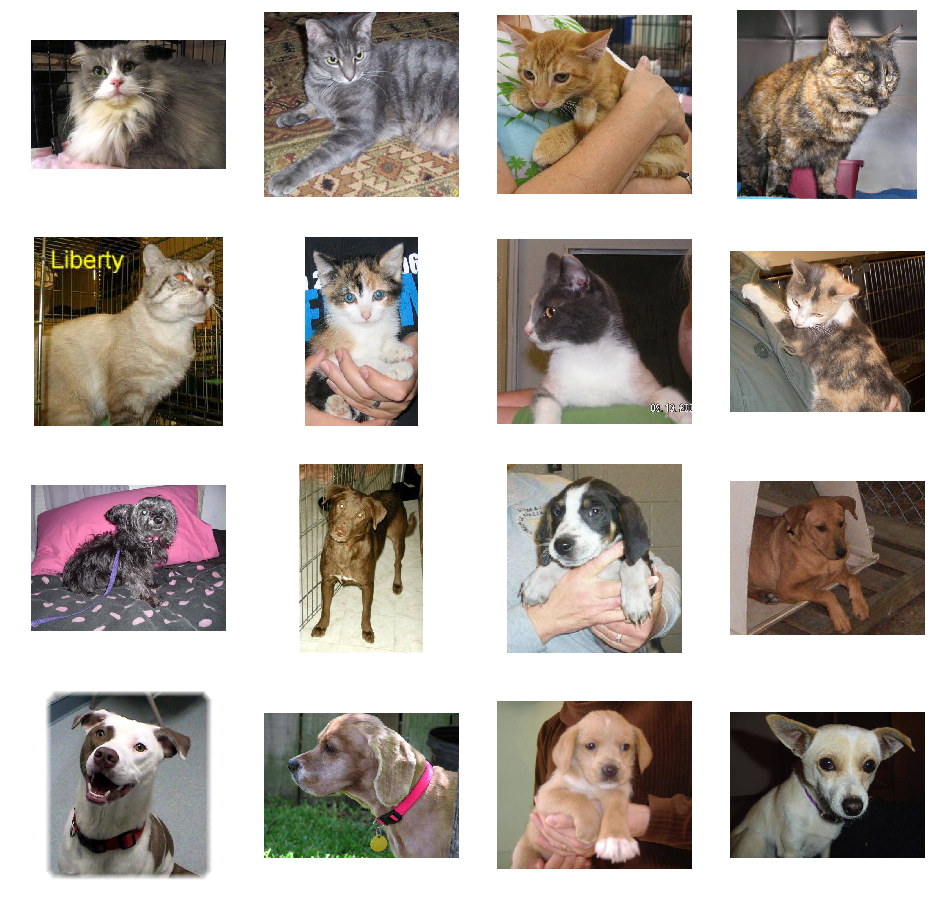

In [11]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# Building a Small Convnet from Scratch to Get to 72% Accuracy
The images that will go into our convnet are 150x150 color images (in the next section on Data Preprocessing, we'll add handling to resize all the images to 150x150 before feeding them into the neural network).

Let's code up the architecture. We will stack 3 {convolution + relu + maxpooling} modules. Our convolutions operate on 3x3 windows and our maxpooling layers operate on 2x2 windows. Our first convolution extracts 16 filters, the following one extracts 32 filters, and the last one extracts 64 filters.

NOTE: This is a configuration that is widely used and known to work well for image classification. Also, since we have relatively few training examples (1,000), using just three convolutional modules keeps the model small, which lowers the risk of overfitting (which we'll explore in more depth in Exercise 2.)

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [0]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

On top of it we stick two fully-connected layers. Because we are facing a two-class classification problem, i.e. a binary classification problem, we will end our network with a sigmoid activation, so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [0]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

Let's summarize the model architecture:

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
__________

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the feature map.

Next, we'll configure the specifications for model training. We will train our model with the binary_crossentropy loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the Machine Learning Crash Course.) We will use the rmsprop optimizer with a learning rate of 0.001. During training, we will want to monitor classification accuracy.

NOTE: In this case, using the RMSprop optimization algorithm is preferable to stochastic gradient descent (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as Adam and Adagrad, also automatically adapt the learning rate during training, and would work equally well here.)

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

# Data Preprocessing
Let's set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit_generator, evaluate_generator, and predict_generator.

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Training
Let's train on all 2,000 images available, for 15 epochs, and validate on all 1,000 test images. (This may take a few minutes to run.)

In [21]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15
 - 89s - loss: 1.1632 - acc: 0.5455 - val_loss: 0.6737 - val_acc: 0.6300
Epoch 2/15
 - 86s - loss: 0.6415 - acc: 0.6330 - val_loss: 0.6196 - val_acc: 0.6510
Epoch 3/15
 - 87s - loss: 0.5527 - acc: 0.7245 - val_loss: 0.5961 - val_acc: 0.6850
Epoch 4/15
 - 87s - loss: 0.4573 - acc: 0.7810 - val_loss: 0.5548 - val_acc: 0.7240
Epoch 5/15
 - 87s - loss: 0.3533 - acc: 0.8390 - val_loss: 0.6552 - val_acc: 0.7150
Epoch 6/15
 - 86s - loss: 0.2611 - acc: 0.8815 - val_loss: 0.8078 - val_acc: 0.6860
Epoch 7/15
 - 87s - loss: 0.1808 - acc: 0.9370 - val_loss: 0.8166 - val_acc: 0.7300
Epoch 8/15
 - 87s - loss: 0.1201 - acc: 0.9600 - val_loss: 0.9502 - val_acc: 0.7400
Epoch 9/15
 - 87s - loss: 0.0803 - acc: 0.9705 - val_loss: 1.2538 - val_acc: 0.7070
Epoch 10/15
 - 87s - loss: 0.0681 - acc: 0.9790 - val_loss: 1.3363 - val_acc: 0.7260
Epoch 11/15
 - 87s - loss: 0.0320 - acc: 0.9900 - val_loss: 2.2469 - val_acc: 0.6640
Epoch 12/15
 - 88s - loss: 0.0514 - acc: 0.9840 - val_loss: 1.3950 - val_a

# Visualizing Intermediate Representations
To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random cat or dog image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


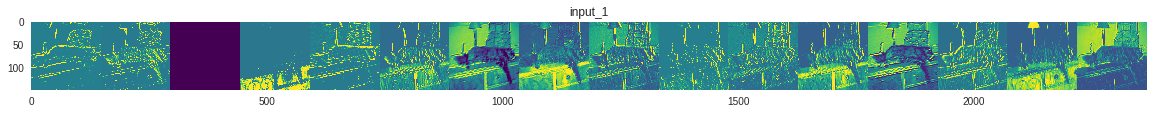

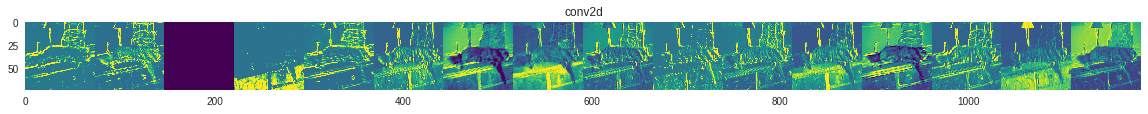

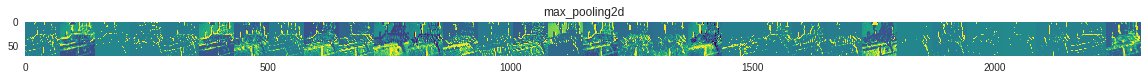

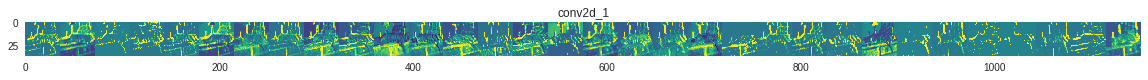

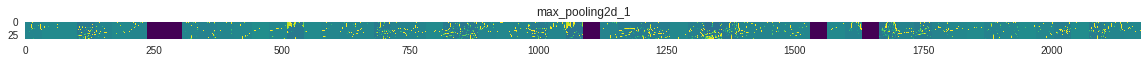

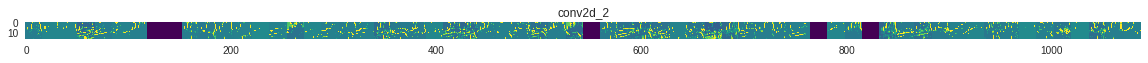

In [22]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

As you can see we go from the raw pixels of the images to increasingly abstract and compact representations. The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called "sparsity." Representation sparsity is a key feature of deep learning.

These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a convnet (or a deep network in general) as an information distillation pipeline.



# Evaluating Accuracy and Loss for the Model
Let's plot the training/validation accuracy and loss as collected during training:

Text(0.5,1,'Training and validation loss')

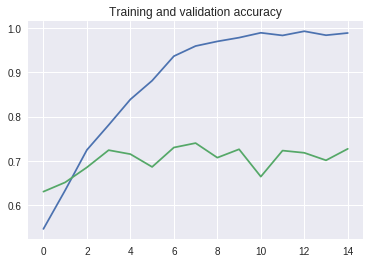

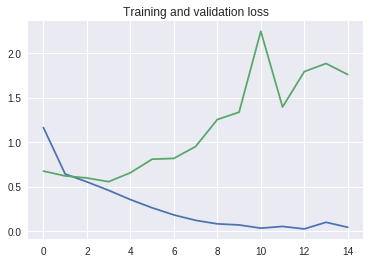

In [23]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

As you can see, we are overfitting like it's getting out of fashion. Our training accuracy (in blue) gets close to 100% (!) while our validation accuracy (in green) stalls as 70%. Our validation loss reaches its minimum after only five epochs.

Since we have a relatively small number of training examples (2000), overfitting should be our number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning: given that we are fitting the parameters of our model to a given dataset, how can we make sure that the representations learned by the model will be applicable to data never seen before? How do we avoid learning things that are specific to the training data?

In the next exercise, we'll look at ways to prevent overfitting in the cat vs. dog classification model.

# Clean Up
Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [0]:
# import os, signal
# os.kill(os.getpid(), signal.SIGKILL)

# Cat vs. Dog Image Classification
# Reducing Overfitting

In this notebook we will build on the model we created in Exercise 1 to classify cats vs. dogs, and improve accuracy by employing a couple strategies to reduce overfitting: data augmentation and dropout.

We will follow these steps:

1. Explore how data augmentation works by making random transformations to training images.
2. Add data augmentation to our data preprocessing.
3. Add dropout to the convnet.
4. Retrain the model and evaluate loss and accuracy.

# Exploring Data Augmentation
Let's get familiar with the concept of data augmentation, an essential way to fight overfitting for computer vision models.

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that at training time, our model will never see the exact same picture twice. This helps prevent overfitting and helps the model generalize better.

This can be done by configuring a number of random transformations to be performed on the images read by our ImageDataGenerator instance. Let's get started with an example:

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation. Let's quickly go over what we just wrote:

rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
shear_range is for randomly applying shearing transformations.
zoom_range is for randomly zooming inside pictures.
horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.
Let's take a look at our augmented images. First let's set up our example files, as in previous section.

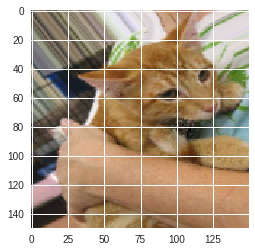

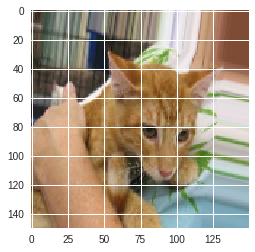

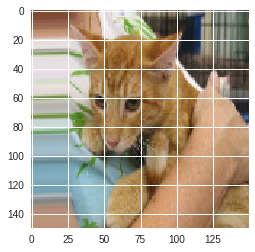

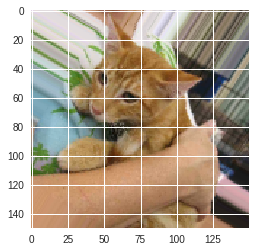

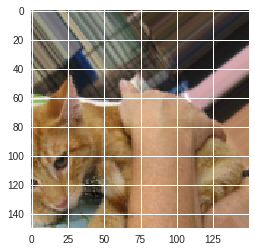

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

# Add Data Augmentation to the Preprocessing Step
Now let's add our data-augmentation transformations from Exploring Data Augmentation to our data preprocessing configuration:

In [26]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


If we train a new network using this data augmentation configuration, our network will never see the same input twice. However the inputs that it sees are still heavily intercorrelated, so this might not be quite enough to completely get rid of overfitting.

# Adding Dropout
Another popular strategy for fighting overfitting is to use dropout.

Let's reconfigure our convnet architecture to add some dropout, right before the final classification layer:

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

# Retrain the Model
With data augmentation and dropout in place, let's retrain our convnet model. This time, let's train on all 2,000 images available, for 30 epochs, and validate on all 1,000 test images. (This may take a few minutes to run.) See if you can write the code yourself:



WRITE CODE TO TRAIN THE MODEL ON ALL 2000 IMAGES FOR 30 EPOCHS, AND VALIDATE 
ON ALL 1,000 TEST IMAGES

### Solution

Click below for the solution.

## Evaluate the Results

Let's evaluate the results of model training with data augmentation and dropout:

Text(0.5,1,'Training and validation loss')

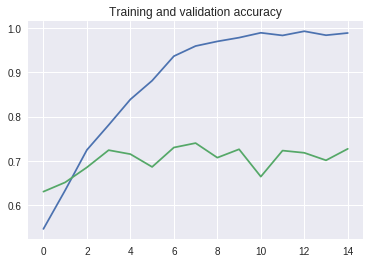

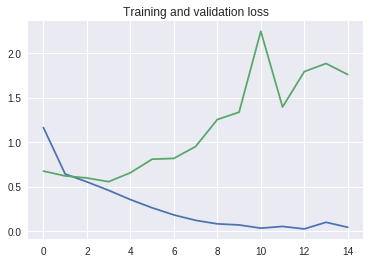

In [28]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Much better! We are no longer overfitting, and we have gained ~3 validation accuracy percentage points (see the green line in the top chart). In fact, judging by our training profile, we could keep fitting our model for 30+ more epochs and we could probably get to ~80%!

# Cat vs. Dog Image Classification
## Feature Extraction and Fine-Tuning

In previous, we built a convnet from scratch, and were able to achieve an accuracy of about 70%. With the addition of data augmentation and dropout in Exercise 2, we were able to increase accuracy to about 80%. That seems decent, but 20% is still too high of an error rate. Maybe we just don't have enough training data available to properly solve the problem. What other approaches can we try?

In this exercise, we'll look at two techniques for repurposing feature data generated from image models that have already been trained on large sets of data, **feature extraction** and **fine tuning**, and use them to improve the accuracy of our cat vs. dog classification model.

## Feature Extraction Using a Pretrained Model

One thing that is commonly done in computer vision is to take a model trained on a very large dataset, run it on your own, smaller dataset, and extract the intermediate representations (features) that the model generates. These representations are frequently informative for your own computer vision task, even though the task may be quite different from the problem that the original model was trained on. This versatility and repurposability of convnets is one of the most interesting aspects of deep learning.

In our case, we will use the [Inception V3 model](https://arxiv.org/abs/1512.00567) developed at Google, and pre-trained on [ImageNet](http://image-net.org/), a large dataset of web images (1.4M images and 1000 classes). This is a powerful model; let's see what the features that it has learned can do for our cat vs. dog problem.

First, we need to pick which intermediate layer of Inception V3 we will use for feature extraction. A common practice is to use the output of the very last layer before the `Flatten` operation, the so-called "bottleneck layer." The reasoning here is that the following fully connected layers will be too specialized for the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.

Let's instantiate an Inception V3 model preloaded with weights trained on ImageNet:


In [0]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

Now let's download the weights:

In [30]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2018-11-09 08:04:36--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  71.5MB/s    in 1.2s    

2018-11-09 08:04:38 (71.5 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

By specifying the `include_top=False` argument, we load a network that doesn't include the classification layers at the top—ideal for feature extraction.

Let's make the model non-trainable, since we will only use it for feature extraction; we won't update the weights of the pretrained model during training.

In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False

The layer we will use for feature extraction in Inception v3 is called `mixed7`. It is not the bottleneck of the network, but we are using it to keep a sufficiently large feature map (7x7 in this case). (Using the bottleneck layer would have resulting in a 3x3 feature map, which is a bit small.) Let's get the output from `mixed7`:

In [34]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 768)


Now let's stick a fully connected classifier on top of `last_output`:

In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

For examples and data preprocessing, let's use the same files and `train_generator` as we did in Exercise 2.

In [36]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2018-11-09 08:10:13--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  77.0MB/s    in 0.9s    

2018-11-09 08:10:14 (77.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [37]:
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Finally, let's train the model using the features we extracted. We'll train on all 2000 images available, for 2 epochs, and validate on all 1,000 test images.

In [38]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/2
 - 221s - loss: 0.5063 - acc: 0.7570 - val_loss: 0.3487 - val_acc: 0.9030
Epoch 2/2
 - 214s - loss: 0.3809 - acc: 0.8385 - val_loss: 0.4701 - val_acc: 0.9030


You can see that we reach a validation accuracy of 88–90% very quickly. This is much better than the small model we trained from scratch.

## Further Improving Accuracy with Fine-Tuning

In our feature-extraction experiment, we only tried adding two classification layers on top of an Inception V3 layer. The weights of the pretrained network were not updated during training. One way to increase performance even further is to "fine-tune" the weights of the top layers of the pretrained model alongside the training of the top-level classifier. A couple of important notes on fine-tuning:

- **Fine-tuning should only be attempted *after* you have trained the top-level classifier with the pretrained model set to non-trainable**. If you add a randomly initialized classifier on top of a pretrained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier), and your pretrained model will just forget everything it has learned.
- Additionally, we **fine-tune only the *top layers* of the pre-trained model** rather than all layers of the pretrained model because, in a convnet, the higher up a layer is, the more specialized it is. The first few layers in a convnet learn very simple and generic features, which generalize to almost all types of images. But as you go higher up, the features are increasingly specific to the dataset that the model is trained on. The goal of fine-tuning is to adapt these specialized features to work with the new dataset.

All we need to do to implement fine-tuning is to set the top layers of Inception V3 to be trainable, recompile the model (necessary for these changes to take effect), and resume training. Let's unfreeze all layers belonging to the `mixed7` module—i.e., all layers found after `mixed6`—and recompile the model:

In [0]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

Now let's retrain the model. We'll train on all 2000 images available, for 50 epochs, and validate on all 1,000 test images. (This may take 15-20 minutes to run.)

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

We are seeing a nice improvement, with the validation loss going from ~1.7 down to ~1.2, and accuracy going from 88% to 92%. That's a 4.5% relative improvement in accuracy.

Let's plot the training and validation loss and accuracy to show it conclusively:

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Congratulations! Using feature extraction and fine-tuning, you've built an image classification model that can identify cats vs. dogs in images with over 90% accuracy.